<a href="https://colab.research.google.com/github/LinAhmed/ML_Ma_Camp_Opt/blob/main/ChrunFinalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn==1.5.2 # Install a version less than 1.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 26.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [ ]:
! pip install catboost

In [ ]:
!pip install xgboost lightgbm catboost --upgrade -q


import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, average_precision_score,
                           confusion_matrix)
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import warnings
warnings.simplefilter(action="ignore")

# ----------------------
# ENHANCED FEATURE ENGINEERING
# ----------------------
def preprocess_data(df):
    """Preprocess data with enhanced features"""
    if 'customerID' in df.columns:
        df = df.drop('customerID', axis=1)

    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')
    df = df.dropna()

    if 'Churn' in df.columns:
        df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

    # Feature engineering
    df['MonthlyCharges_to_Total_Ratio'] = df['MonthlyCharges'] / df['TotalCharges']
    df["NEW_Engaged"] = df["Contract"].apply(lambda x: 1 if x in ["One year","Two year"] else 0)
    df["Lack_of_Protections"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or
                               (x["DeviceProtection"] != "Yes") or
                               (x["TechSupport"] != "Yes") else 0, axis=1)
    df["Young_Unengaged_Customers"] = df.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and
                                         (x["SeniorCitizen"] == 0) else 0, axis=1)
    df['Total_Active_Services'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                                 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                 'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)
    df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or
                                          (x["StreamingMovies"] == "Yes") else 0, axis=1)
    df["AutoPayment_Usage"] = df["PaymentMethod"].apply(lambda x: 1 if x in
                                                         ["Bank transfer (automatic)",
                                                          "Credit card (automatic)"] else 0)
    df["Average_Charge_Per_Month"] = df["TotalCharges"] / df['tenure']
    df["NEW_Increase"] = df["Average_Charge_Per_Month"] / df["MonthlyCharges"]
    df["Average_Service_Cost"] = df["MonthlyCharges"] / (df['Total_Active_Services'] + 1)

    # Precision-focused features
    df["Unstable_Payment_Behavior"] = ((df["PaymentMethod"] == "Electronic check") &
                                 (df["Contract"] == "Month-to-month")).astype(int)
    df["HighRisk_Low_Tenure"] = ((df["tenure"] < 6) &
                               (df["OnlineSecurity"] == "No")).astype(int)
    df["Tenure_Group"] = pd.cut(df['tenure'],
                                   bins=[0, 12, 24, 60, 100],
                                   labels=['New', '1Y', '2Y', 'LongTerm'])
    df["Service_Instability"] = ((df["OnlineSecurity"] == "No") &
                                    (df["TechSupport"] == "No")).astype(int)
    df["HighSpend_LowTenure"] = ((df["MonthlyCharges"] > 70) &
                                   (df["tenure"] < 6)).astype(int)


    return df

# ----------------------
# F1-OPTIMIZED THRESHOLD FINDER
# ----------------------
def optimize_threshold(model, X, y, min_precision=0.7, min_recall=0.7, n_splits=3):
    """Find optimal threshold that maximizes F1 while meeting precision/recall constraints"""
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_probas = cross_val_predict(model, X, y, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]

    thresholds = np.linspace(0.1, 0.9, 100)
    best_f1 = -1
    best_threshold = 0.5

    for thresh in thresholds:
        y_pred = (y_probas >= thresh).astype(int)
        current_recall = recall_score(y, y_pred)
        current_precision = precision_score(y, y_pred)
        current_f1 = f1_score(y, y_pred)

        if current_precision >= min_precision and current_recall >= min_recall:
            if current_f1 > best_f1:
                best_f1 = current_f1
                best_threshold = thresh

    # Fallback: Maximize F1 if no threshold meets constraints
    if best_f1 == -1:
        for thresh in thresholds:
            y_pred = (y_probas >= thresh).astype(int)
            current_f1 = f1_score(y, y_pred)
            if current_f1 > best_f1:
                best_f1 = current_f1
                best_threshold = thresh

    return best_threshold

# ----------------------
# MODEL TUNING WITH CLASS WEIGHTS
# ----------------------
def tune_model(model, param_grid, X, y, cv=3, n_iter=30):
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring='average_precision',
        cv=StratifiedKFold(5, shuffle=True, random_state=42),
        verbose=0,
        random_state=42,
        n_jobs=-1
    )
    search.fit(X, y)
    return search.best_estimator_

# ----------------------
# MAIN WORKFLOW
# ----------------------
if __name__ == "__main__":
    # 1. Load and preprocess data
    df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
    df = preprocess_data(df)
    X = df.drop("Churn", axis=1)
    y = df["Churn"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # 2. Calculate class ratios
    pos = y_train.sum()
    neg = len(y_train) - pos
    original_ratio = neg / pos
    sqrt_ratio = np.sqrt(original_ratio)

    # 3. Prepare datasets
    categorical_features = [col for col in X.columns if X[col].dtype == 'object']
    categorical_features.append('Tenure_Group')

    # CatBoost setup
    X_train_catboost = X_train.copy()
    X_test_catboost = X_test.copy()
    for col in categorical_features:
        X_train_catboost[col] = X_train_catboost[col].astype('category')
        X_test_catboost[col] = X_test_catboost[col].astype('category')
    cat_features_indices = [X_train_catboost.columns.get_loc(col) for col in categorical_features]

    # Other models setup
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoder.fit(X_train[categorical_features])

    X_train_encoded = pd.concat([
        X_train.drop(categorical_features, axis=1),
        pd.DataFrame(encoder.transform(X_train[categorical_features]),
                     columns=encoder.get_feature_names_out(categorical_features),
                     index=X_train.index)
    ], axis=1)

    X_test_encoded = pd.concat([
        X_test.drop(categorical_features, axis=1),
        pd.DataFrame(encoder.transform(X_test[categorical_features]),
                     columns=encoder.get_feature_names_out(categorical_features),
                     index=X_test.index)
    ], axis=1)

    # 4. Configure models with dynamic class weights
    base_models = {
        'XGB': XGBClassifier(
            tree_method='hist',
            eval_metric='aucpr',
            random_state=42,
            use_label_encoder=False
        ),
        'LGBM': LGBMClassifier(
            device='cpu',
            random_state=42,
            verbose=-1
        ),
        'CatBoost': CatBoostClassifier(
            task_type='CPU',
            cat_features=cat_features_indices,
            random_seed=42,
            verbose=0
        )
    }

    # 5. Enhanced parameter grids with class weights
    param_grids = {
        'XGB': {
            'scale_pos_weight': [sqrt_ratio, original_ratio, 1, 2, 3],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 4, 6],
            'subsample': [0.6, 0.8],
            'gamma': [0.5, 1, 2],
            'n_estimators': [200, 300],
            'reg_alpha': [0.1, 1, 5],
            'reg_lambda': [1, 10, 20],
            'min_child_weight': [1, 5, 10]
        },
        'LGBM': {
            'scale_pos_weight': [sqrt_ratio, original_ratio, 1, 2, 3],
            'learning_rate': [0.01, 0.05, 0.1],
            'num_leaves': [15, 31, 63],
            'max_depth': [4, 6, 8],
            'subsample': [0.6, 0.8, 0.9],
            'n_estimators': [200, 300],
            'reg_alpha': [0.1, 1, 5],
            'reg_lambda': [1, 10, 20]
        },
        'CatBoost': {
            'scale_pos_weight': [sqrt_ratio, original_ratio, 1, 2, 3],
            'learning_rate': [0.01, 0.05, 0.1],
            'depth': [4, 6, 8],
            'l2_leaf_reg': [1, 3, 5],
            'subsample': [0.6, 0.8, 0.9],
            'iterations': [200, 300],
            'min_data_in_leaf': [20, 50, 100]
        }
    }

    # 6. Tuning and threshold optimization
    best_models = {}
    thresholds = {}

    for name in base_models:
        print(f"\n⚡ Tuning {name}...")
        tuning_data = X_train_catboost if name == 'CatBoost' else X_train_encoded
        model = tune_model(base_models[name], param_grids[name], tuning_data, y_train)

        # Extract and print best parameters
        best_params = {param: model.get_params()[param] for param in param_grids[name].keys()}
        print(f"⭐ Best parameters for {name}:")
        for k, v in best_params.items():
            print(f"{k}: {v}")

        print(f"⚙️ Optimizing threshold for {name}...")
        best_threshold = optimize_threshold(model, tuning_data, y_train)
        thresholds[name] = best_threshold
        best_models[name] = model
        print(f"✅ Optimal threshold for {name}: {best_threshold:.4f}")

    # 7. Final evaluation with optimized thresholds
    print("\n\n🚀 Final Results with Optimized Thresholds:")
    results = []
    for name, model in best_models.items():
        test_data = X_test_catboost if name == 'CatBoost' else X_test_encoded
        y_proba = model.predict_proba(test_data)[:, 1]
        y_pred = (y_proba >= thresholds[name]).astype(int)

        metrics = {
            'Model': name,
            'Threshold': thresholds[name],
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            'PR-AUC': average_precision_score(y_test, y_proba),
            'ROC-AUC': roc_auc_score(y_test, y_proba)
        }
        results.append(metrics)
        print(f"\n{name} Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

    print("\n📊 Performance Summary:")
    summary = pd.DataFrame(results).set_index('Model')
    print(summary.round(4))

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)



⚡ Tuning XGB...
⭐ Best parameters for XGB:
scale_pos_weight: 1
learning_rate: 0.01
max_depth: 6
subsample: 0.6
gamma: 2
n_estimators: 300
reg_alpha: 1
reg_lambda: 1
min_child_weight: 10
⚙️ Optimizing threshold for XGB...
✅ Optimal threshold for XGB: 0.3101

⚡ Tuning LGBM...
⭐ Best parameters for LGBM:
scale_pos_weight: 1.6620895902507984
learning_rate: 0.01
num_leaves: 15
max_depth: 4
subsample: 0.8
n_estimators: 300
reg_alpha: 1
reg_lambda: 10
⚙️ Optimizing threshold for LGBM...
✅ Optimal threshold for LGBM: 0.4232

⚡ Tuning CatBoost...
⭐ Best parameters for CatBoost:
scale_pos_weight: 2.762541806020067
learning_rate: 0.05
depth: 4
l2_leaf_reg: 5
subsample: 0.9
iterations: 200
min_data_in_leaf: 100
⚙️ Optimizing threshold for CatBoost...
✅ Optimal threshold for CatBoost: 0.5929


🚀 Final Results with Optimized Thresholds:

XGB Confusion Matrix:
[[788 245]
 [ 88 286]]

LGBM Confusion Matrix:
[[781 252]
 [ 84 290]]

CatBoost Confusion Matrix:
[[818 215]
 [ 99 275]]

📊 Performance Summa

# Hardcoded parameters and thresholds from the above tuning

In [ ]:
!pip install xgboost lightgbm catboost --upgrade -q

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, average_precision_score,
                           confusion_matrix)
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import warnings
warnings.simplefilter(action="ignore")

# ----------------------
# ENHANCED FEATURE ENGINEERING
# ----------------------
def preprocess_data(df):
    """Preprocess data with enhanced features"""
    if 'customerID' in df.columns:
        df = df.drop('customerID', axis=1)

    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')
    df = df.dropna()

    if 'Churn' in df.columns:
        df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

    # Feature engineering
    df['MonthlyCharges_to_Total_Ratio'] = df['MonthlyCharges'] / df['TotalCharges']
    df["NEW_Engaged"] = df["Contract"].apply(lambda x: 1 if x in ["One year","Two year"] else 0)
    df["Lack_of_Protections"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or
                               (x["DeviceProtection"] != "Yes") or
                               (x["TechSupport"] != "Yes") else 0, axis=1)
    df["Young_Unengaged_Customers"] = df.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and
                                         (x["SeniorCitizen"] == 0) else 0, axis=1)
    df['Total_Active_Services'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                                 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                 'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)
    df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or
                                          (x["StreamingMovies"] == "Yes") else 0, axis=1)
    df["AutoPayment_Usage"] = df["PaymentMethod"].apply(lambda x: 1 if x in
                                                         ["Bank transfer (automatic)",
                                                          "Credit card (automatic)"] else 0)
    df["Average_Charge_Per_Month"] = df["TotalCharges"] / df['tenure']
    df["NEW_Increase"] = df["Average_Charge_Per_Month"] / df["MonthlyCharges"]
    df["Average_Service_Cost"] = df["MonthlyCharges"] / (df['Total_Active_Services'] + 1)

    # Precision-focused features
    df["Unstable_Payment_Behavior"] = ((df["PaymentMethod"] == "Electronic check") &
                                 (df["Contract"] == "Month-to-month")).astype(int)
    df["HighRisk_Low_Tenure"] = ((df["tenure"] < 6) &
                               (df["OnlineSecurity"] == "No")).astype(int)
    df["Tenure_Group"] = pd.cut(df['tenure'],
                                   bins=[0, 12, 24, 60, 100],
                                   labels=['New', '1Y', '2Y', 'LongTerm'])
    df["Service_Instability"] = ((df["OnlineSecurity"] == "No") &
                                    (df["TechSupport"] == "No")).astype(int)
    df["HighSpend_LowTenure"] = ((df["MonthlyCharges"] > 70) &
                                   (df["tenure"] < 6)).astype(int)


    return df

# ----------------------
# MAIN WORKFLOW
# ----------------------
if __name__ == "__main__":
    # 1. Load and preprocess data
    df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
    df = preprocess_data(df)
    X = df.drop("Churn", axis=1)
    y = df["Churn"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # 2. Prepare datasets
    categorical_features = [col for col in X.columns if X[col].dtype == 'object']
    categorical_features.append('Tenure_Group')

    # CatBoost setup
    X_train_catboost = X_train.copy()
    X_test_catboost = X_test.copy()
    for col in categorical_features:
        X_train_catboost[col] = X_train_catboost[col].astype('category')
        X_test_catboost[col] = X_test_catboost[col].astype('category')
    cat_features_indices = [X_train_catboost.columns.get_loc(col) for col in categorical_features]

    # Other models setup
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoder.fit(X_train[categorical_features])

    X_train_encoded = pd.concat([
        X_train.drop(categorical_features, axis=1),
        pd.DataFrame(encoder.transform(X_train[categorical_features]),
                     columns=encoder.get_feature_names_out(categorical_features),
                     index=X_train.index)
    ], axis=1)

    X_test_encoded = pd.concat([
        X_test.drop(categorical_features, axis=1),
        pd.DataFrame(encoder.transform(X_test[categorical_features]),
                     columns=encoder.get_feature_names_out(categorical_features),
                     index=X_test.index)
    ], axis=1)

    # 3. Initialize models with hardcoded parameters
    best_models = {
        'XGB': XGBClassifier(
            tree_method='hist',
            eval_metric='aucpr',
            random_state=42,
            use_label_encoder=False,
            scale_pos_weight=1,
            learning_rate=0.01,
            max_depth=6,
            subsample=0.6,
            gamma=2,
            n_estimators=300,
            reg_alpha=1,
            reg_lambda=1,
            min_child_weight=10
        ),
        'LGBM': LGBMClassifier(
            device='cpu',
            random_state=42,
            verbose=-1,
            scale_pos_weight=1.6620895902507984,
            learning_rate=0.01,
            num_leaves=15,
            max_depth=4,
            subsample=0.8,
            n_estimators=300,
            reg_alpha=1,
            reg_lambda=10
        ),
        'CatBoost': CatBoostClassifier(
            task_type='CPU',
            cat_features=cat_features_indices,
            random_seed=42,
            verbose=0,
            scale_pos_weight=2.762541806020067,
            learning_rate=0.05,
            depth=4,
            l2_leaf_reg=5,
            subsample=0.9,
            iterations=200,
            min_data_in_leaf=100
        )
    }

    # 4. Train models
    best_models['XGB'].fit(X_train_encoded, y_train)
    best_models['LGBM'].fit(X_train_encoded, y_train)
    best_models['CatBoost'].fit(X_train_catboost, y_train)

    # 5. Hardcoded thresholds
    thresholds = {
        'XGB': 0.3101,
        'LGBM': 0.4232,
        'CatBoost': 0.5929
    }

    # 6. Final evaluation
    print("\n🚀 Final Results with Hardcoded Thresholds:")
    results = []
    for name, model in best_models.items():
        test_data = X_test_catboost if name == 'CatBoost' else X_test_encoded
        y_proba = model.predict_proba(test_data)[:, 1]
        y_pred = (y_proba >= thresholds[name]).astype(int)

        metrics = {
            'Model': name,
            'Threshold': thresholds[name],
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            'PR-AUC': average_precision_score(y_test, y_proba),
            'ROC-AUC': roc_auc_score(y_test, y_proba)
        }
        results.append(metrics)
        print(f"\n{name} Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

    print("\n📊 Performance Summary:")
    summary = pd.DataFrame(results).set_index('Model')
    print(summary.round(4))

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)



🚀 Final Results with Hardcoded Thresholds:

XGB Confusion Matrix:
[[788 245]
 [ 88 286]]

LGBM Confusion Matrix:
[[781 252]
 [ 84 290]]

CatBoost Confusion Matrix:
[[818 215]
 [ 99 275]]

📊 Performance Summary:
          Threshold  Accuracy  Precision  Recall      F1  PR-AUC  ROC-AUC
Model                                                                    
XGB          0.3101    0.7633     0.5386  0.7647  0.6320  0.6481   0.8408
LGBM         0.4232    0.7612     0.5351  0.7754  0.6332  0.6478   0.8397
CatBoost     0.5929    0.7768     0.5612  0.7353  0.6366  0.6553   0.8403


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=['Stayed', 'Churned'], output_dict=True)

# Convert to DataFrame for better formatting
df_report = pd.DataFrame(report).transpose()

# Round all numeric values to 3 decimal places
df_report = df_report.round(3)

# Print the formatted report
print("\nClassification Report:")
print("-" * 60)
print(df_report.to_string())

# Calculate and print additional metrics
print("\nDetailed Class-wise Analysis:")
print("-" * 60)
print(f"Stayed (Class 0):")
print(f"Total Predictions: {len(y_test[y_test == 0])}")
print(f"Correct Predictions: {len(y_test[(y_test == 0) & (y_pred == 0)])}")
print(f"Misclassified: {len(y_test[(y_test == 0) & (y_pred == 1)])}")

print(f"\nChurned (Class 1):")
print(f"Total Predictions: {len(y_test[y_test == 1])}")
print(f"Correct Predictions: {len(y_test[(y_test == 1) & (y_pred == 1)])}")
print(f"Misclassified: {len(y_test[(y_test == 1) & (y_pred == 0)])}")


Classification Report:
------------------------------------------------------------
              precision  recall  f1-score   support
Stayed            0.892   0.792     0.839  1033.000
Churned           0.561   0.735     0.637   374.000
accuracy          0.777   0.777     0.777     0.777
macro avg         0.727   0.764     0.738  1407.000
weighted avg      0.804   0.777     0.785  1407.000

Detailed Class-wise Analysis:
------------------------------------------------------------
Stayed (Class 0):
Total Predictions: 1033
Correct Predictions: 818
Misclassified: 215

Churned (Class 1):
Total Predictions: 374
Correct Predictions: 275
Misclassified: 99


In [ ]:
from sklearn.metrics import classification_report

# Generate and print simple classification report
print("\nClassification Report:")
print("-" * 60)
print(classification_report(y_test, y_pred,
                          target_names=['Stayed', 'Churned'],
                          digits=3))


Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

      Stayed      0.892     0.792     0.839      1033
     Churned      0.561     0.735     0.637       374

    accuracy                          0.777      1407
   macro avg      0.727     0.764     0.738      1407
weighted avg      0.804     0.777     0.785      1407



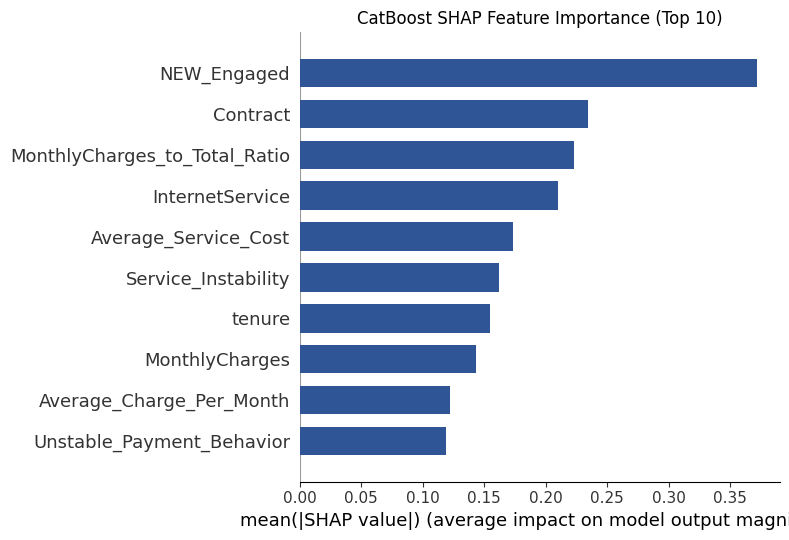

In [ ]:
# ----------------------
# Feature Importance Plots for CatBoost
# ----------------------
import shap
import matplotlib.pyplot as plt

# CatBoost model
model = best_models['CatBoost']

# SHAP Importance
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_catboost)

# Get feature importance values
feature_importance = np.abs(shap_values).mean(0)
feature_names = X_test_catboost.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)

# Select top 10 features
top_10_features = importance_df['feature'].head(10).values

# Create mask for top 10 features
mask = X_test_catboost.columns.isin(top_10_features)

plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values[:, mask],
    X_test_catboost.iloc[:, mask],
    plot_type="bar",
    show=False,
    color='#2F5597'
)
plt.title("CatBoost SHAP Feature Importance (Top 10)")
plt.tight_layout()
plt.show()

<Figure size 700x500 with 0 Axes>

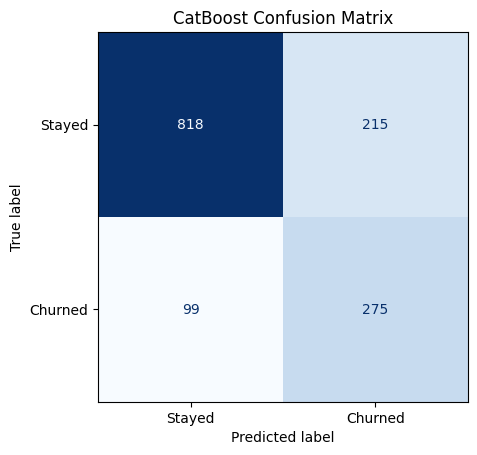

<Figure size 800x600 with 0 Axes>

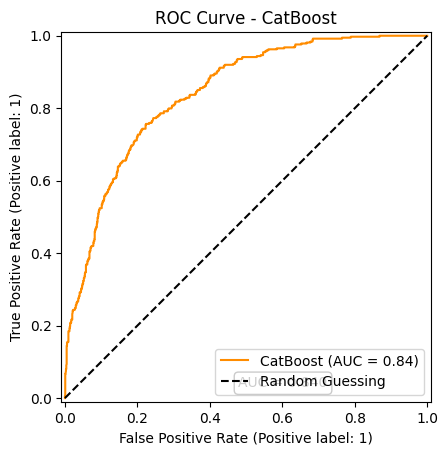

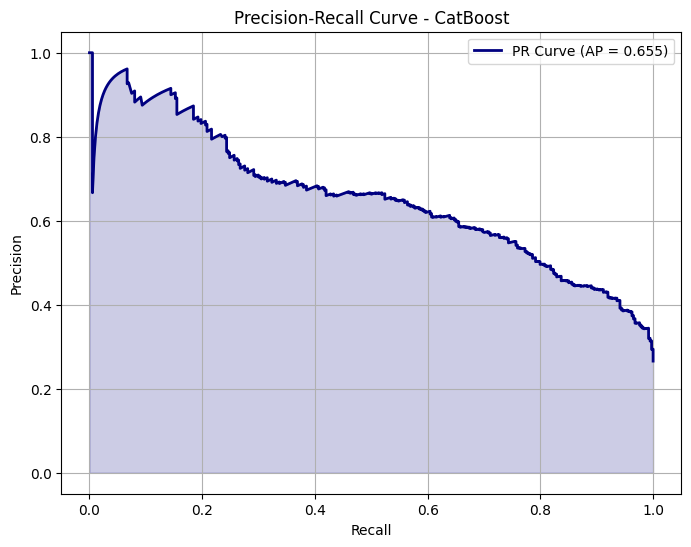

In [ ]:
    # ----------------------
    # Advanced Model Diagnostics for CatBoost
    # ----------------------
    from sklearn.metrics import (roc_curve, precision_recall_curve,
                               ConfusionMatrixDisplay, RocCurveDisplay)

    # Get CatBoost model and predictions
    model = best_models['CatBoost']
    y_proba = model.predict_proba(X_test_catboost)[:, 1]


    # 1. Enhanced Confusion Matrix
    plt.figure(figsize=(7, 5))
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        cmap='Blues',
        display_labels=['Stayed', 'Churned'],
        colorbar=False
    )
    plt.title("CatBoost Confusion Matrix")
    plt.grid(False)
    plt.show()

    # 2. ROC Curve with Annotated AUC
    plt.figure(figsize=(8, 6))
    RocCurveDisplay.from_estimator(
        model,
        X_test_catboost,
        y_test,
        name='CatBoost',
        color='darkorange'
    )
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
    plt.annotate(f'AUC = {roc_auc_score(y_test, y_proba):.3f}',
                 xy=(0.6, 0.05), xycoords='axes fraction',
                 ha='center', va='center',
                 bbox=dict(boxstyle="round", fc="white"))
    plt.title('ROC Curve - CatBoost')
    plt.legend(loc='lower right')
    plt.show()

    # 3. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='navy', lw=2,
             label=f'PR Curve (AP = {average_precision_score(y_test, y_proba):.3f})')
    plt.fill_between(recall, precision, alpha=0.2, color='navy')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - CatBoost')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()



<Figure size 800x600 with 0 Axes>

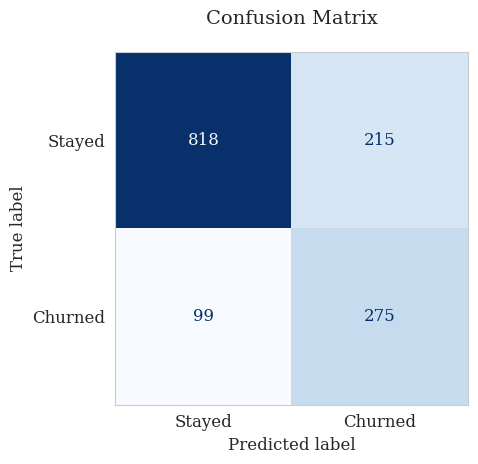

<Figure size 800x600 with 0 Axes>

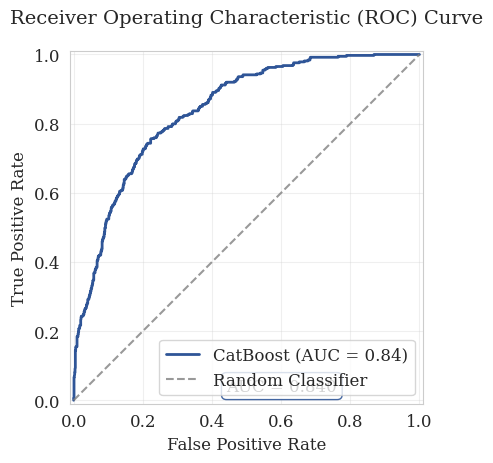

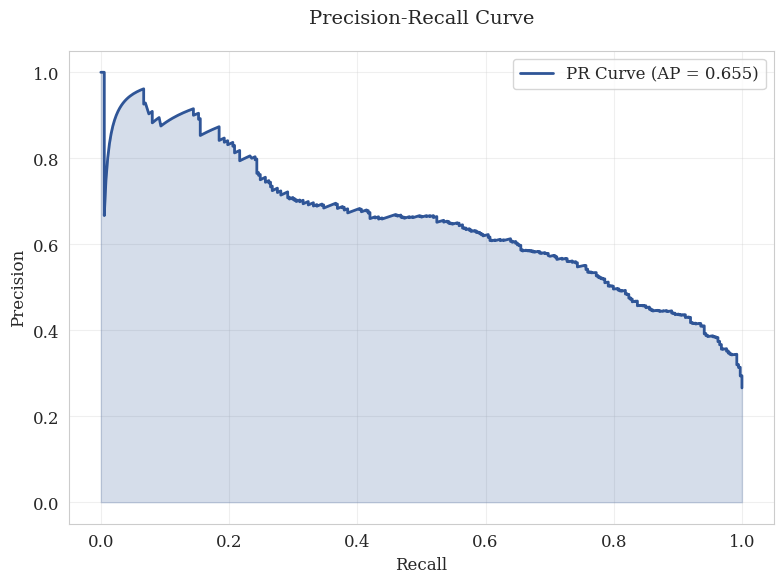

In [ ]:
# ----------------------
# Advanced Model Diagnostics for CatBoost
# ----------------------
import seaborn as sns #
from sklearn.metrics import (roc_curve, precision_recall_curve,
                           ConfusionMatrixDisplay, RocCurveDisplay)
import matplotlib.pyplot as plt

# Set style parameters for thesis-quality plots
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
thesis_blue = '#2F5597'
thesis_orange = '#C55A11'

# Get CatBoost model and predictions
model = best_models['CatBoost']
y_proba = model.predict_proba(X_test_catboost)[:, 1]

# 1. Enhanced Confusion Matrix
plt.figure(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    cmap='Blues',
    display_labels=['Stayed', 'Churned'],
    colorbar=False
)
cm_display.ax_.set_title("Confusion Matrix", pad=20)
cm_display.ax_.grid(False)
plt.tight_layout()
plt.show()

# 2. ROC Curve with Annotated AUC
plt.figure(figsize=(8, 6))
roc_display = RocCurveDisplay.from_estimator(
    model,
    X_test_catboost,
    y_test,
    name='CatBoost',
    color=thesis_blue,
    lw=2
)
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Classifier', alpha=0.8)
plt.annotate(f'AUC = {roc_auc_score(y_test, y_proba):.3f}',
             xy=(0.6, 0.05), xycoords='axes fraction',
             ha='center', va='center',
             bbox=dict(boxstyle="round", fc="white", ec=thesis_blue, alpha=0.9))
plt.title('Receiver Operating Characteristic (ROC) Curve', pad=20)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color=thesis_blue, lw=2,
         label=f'PR Curve (AP = {average_precision_score(y_test, y_proba):.3f})')
plt.fill_between(recall, precision, alpha=0.2, color=thesis_blue)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve', pad=20)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.ylim(-0.05, 1.05)
plt.xlim(-0.05, 1.05)
plt.tight_layout()
plt.show()

# weighted avg metrics

In [ ]:
!pip install xgboost lightgbm catboost --upgrade -q


import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, average_precision_score,
                           confusion_matrix)
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import warnings
warnings.simplefilter(action="ignore")

# ----------------------
# ENHANCED FEATURE ENGINEERING
# ----------------------
def preprocess_data(df):
    """Preprocess data with enhanced features"""
    if 'customerID' in df.columns:
        df = df.drop('customerID', axis=1)

    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')
    df = df.dropna()

    if 'Churn' in df.columns:
        df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

    # Feature engineering
    df['MonthlyCharges_to_Total_Ratio'] = df['MonthlyCharges'] / df['TotalCharges']
    df["NEW_Engaged"] = df["Contract"].apply(lambda x: 1 if x in ["One year","Two year"] else 0)
    df["Lack_of_Protections"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or
                               (x["DeviceProtection"] != "Yes") or
                               (x["TechSupport"] != "Yes") else 0, axis=1)
    df["Young_Unengaged_Customers"] = df.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and
                                         (x["SeniorCitizen"] == 0) else 0, axis=1)
    df['Total_Active_Services'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                                 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                 'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)
    df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or
                                          (x["StreamingMovies"] == "Yes") else 0, axis=1)
    df["AutoPayment_Usage"] = df["PaymentMethod"].apply(lambda x: 1 if x in
                                                         ["Bank transfer (automatic)",
                                                          "Credit card (automatic)"] else 0)
    df["Average_Charge_Per_Month"] = df["TotalCharges"] / df['tenure']
    df["NEW_Increase"] = df["Average_Charge_Per_Month"] / df["MonthlyCharges"]
    df["Average_Service_Cost"] = df["MonthlyCharges"] / (df['Total_Active_Services'] + 1)

    # Precision-focused features
    df["Unstable_Payment_Behavior"] = ((df["PaymentMethod"] == "Electronic check") &
                                 (df["Contract"] == "Month-to-month")).astype(int)
    df["HighRisk_Low_Tenure"] = ((df["tenure"] < 6) &
                               (df["OnlineSecurity"] == "No")).astype(int)
    df["Tenure_Group"] = pd.cut(df['tenure'],
                                   bins=[0, 12, 24, 60, 100],
                                   labels=['New', '1Y', '2Y', 'LongTerm'])
    df["Service_Instability"] = ((df["OnlineSecurity"] == "No") &
                                    (df["TechSupport"] == "No")).astype(int)
    df["HighSpend_LowTenure"] = ((df["MonthlyCharges"] > 70) &
                                   (df["tenure"] < 6)).astype(int)


    return df

# ----------------------
# MAIN WORKFLOW
# ----------------------
if __name__ == "__main__":
    # 1. Load and preprocess data
    df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
    df = preprocess_data(df)
    X = df.drop("Churn", axis=1)
    y = df["Churn"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # 2. Prepare datasets
    categorical_features = [col for col in X.columns if X[col].dtype == 'object']
    categorical_features.append('Tenure_Group')

    # CatBoost setup
    X_train_catboost = X_train.copy()
    X_test_catboost = X_test.copy()
    for col in categorical_features:
        X_train_catboost[col] = X_train_catboost[col].astype('category')
        X_test_catboost[col] = X_test_catboost[col].astype('category')
    cat_features_indices = [X_train_catboost.columns.get_loc(col) for col in categorical_features]

    # Other models setup
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoder.fit(X_train[categorical_features])

    X_train_encoded = pd.concat([
        X_train.drop(categorical_features, axis=1),
        pd.DataFrame(encoder.transform(X_train[categorical_features]),
                     columns=encoder.get_feature_names_out(categorical_features),
                     index=X_train.index)
    ], axis=1)

    X_test_encoded = pd.concat([
        X_test.drop(categorical_features, axis=1),
        pd.DataFrame(encoder.transform(X_test[categorical_features]),
                     columns=encoder.get_feature_names_out(categorical_features),
                     index=X_test.index)
    ], axis=1)

    # 3. Initialize models with hardcoded parameters
    best_models = {
        'XGB': XGBClassifier(
            tree_method='hist',
            eval_metric='aucpr',
            random_state=42,
            use_label_encoder=False,
            scale_pos_weight=1,
            learning_rate=0.01,
            max_depth=6,
            subsample=0.6,
            gamma=2,
            n_estimators=300,
            reg_alpha=1,
            reg_lambda=1,
            min_child_weight=10
        ),
        'LGBM': LGBMClassifier(
            device='cpu',
            random_state=42,
            verbose=-1,
            scale_pos_weight=1.6620895902507984,
            learning_rate=0.01,
            num_leaves=15,
            max_depth=4,
            subsample=0.8,
            n_estimators=300,
            reg_alpha=1,
            reg_lambda=10
        ),
        'CatBoost': CatBoostClassifier(
            task_type='CPU',
            cat_features=cat_features_indices,
            random_seed=42,
            verbose=0,
            scale_pos_weight=2.762541806020067,
            learning_rate=0.05,
            depth=4,
            l2_leaf_reg=5,
            subsample=0.9,
            iterations=200,
            min_data_in_leaf=100
        )
    }

    # 4. Train models
    best_models['XGB'].fit(X_train_encoded, y_train)
    best_models['LGBM'].fit(X_train_encoded, y_train)
    best_models['CatBoost'].fit(X_train_catboost, y_train)

    # 5. Hardcoded thresholds
    thresholds = {
        'XGB': 0.3101,
        'LGBM': 0.4232,
        'CatBoost': 0.5929
    }

    # 6. Final evaluation
    print("\n🚀 Final Results with Hardcoded Thresholds:")
    results = []
    for name, model in best_models.items():
        test_data = X_test_catboost if name == 'CatBoost' else X_test_encoded
        y_proba = model.predict_proba(test_data)[:, 1]
        y_pred = (y_proba >= thresholds[name]).astype(int)

        metrics = {
            'Model': name,
            'Threshold': thresholds[name],
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred , average='weighted'),
            'Recall': recall_score(y_test, y_pred , average='weighted'),
            'F1': f1_score(y_test, y_pred , average='weighted'),
            'PR-AUC': average_precision_score(y_test, y_proba),
            'ROC-AUC': roc_auc_score(y_test, y_proba)
        }
        results.append(metrics)
        print(f"\n{name} Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

    print("\n📊 Performance Summary:")
    summary = pd.DataFrame(results).set_index('Model')
    print(summary.round(4))


🚀 Final Results with Hardcoded Thresholds:

XGB Confusion Matrix:
[[788 245]
 [ 88 286]]

LGBM Confusion Matrix:
[[781 252]
 [ 84 290]]

CatBoost Confusion Matrix:
[[818 215]
 [ 99 275]]

📊 Performance Summary:
          Threshold  Accuracy  Precision  Recall      F1  PR-AUC  ROC-AUC
Model                                                                    
XGB          0.3101    0.7633     0.8036  0.7633  0.7741  0.6481   0.8408
LGBM         0.4232    0.7612     0.8051  0.7612  0.7725  0.6478   0.8397
CatBoost     0.5929    0.7768     0.8041  0.7768  0.7852  0.6553   0.8403
